# Analysis for the paper 

## Import all the libraries

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from os import *
from os import listdir
from os.path import isfile, join

/Users/marc/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Spike detection algorithm

In [2]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.5"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

## Generate plots

Read csv files generated with ImageJ after automatic segmentation of the red channel to define ROIs and normalize

In [97]:
#read csv files generated with ImageJ

mypath = 'test'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

results = {}
for file in onlyfiles:
    if file.endswith('.csv'):
        results[path.splitext(file)[0]] = pd.read_csv(join(mypath,file), sep = ',')

#choose frame to normalize and get dF/F
frame = 100
results_norm={}
for file in results:
    norm = results[file].copy()
    for ex in np.arange(1,len(results[file].columns)):

        norm['Mean'+str(ex)] =  (norm['Mean'+str(ex)]-(np.mean(norm['Mean'+str(ex)][1:frame])))/norm['Mean'+str(ex)]
        results_norm[file+'_norm'] = norm.drop(' ', axis=1)


Plot traces

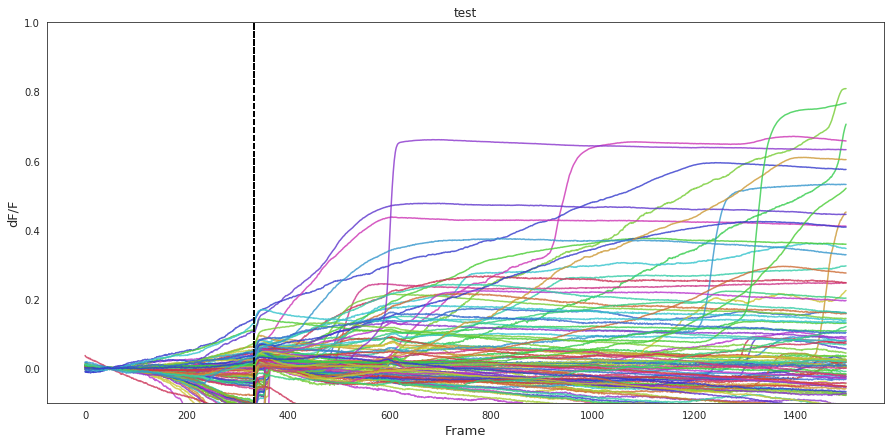

In [98]:

## Generate 

#style for plots


#set stimulation 
stim = 333

sns.set_style("white")
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
fig1 = fig.add_subplot(grid[:, :])
sub_fig = fig1

for file in results_norm:


    for ex in np.arange(1,len(results_norm[file].columns)):

        series = results_norm[file]['Mean'+str(ex)]
        cmap = sns.hls_palette(10,l=.5, s=.6)
        sns.set_palette(cmap)
        plt.plot(series, alpha = 0.8)
       
            #a = a+10
    
        plt.axvline(x = stim , linestyle = '--', color = 'black', alpha =0.7)
        plt.xlabel("Frame",fontdict={'fontsize':13})
        plt.ylabel("dF/F",fontdict={'fontsize':13})
        plt.title(mypath)
        sub_fig.set_ylim(-0.1,1)


plt.show()




Plot heatmap with traces sorted by total GCaMP intensity

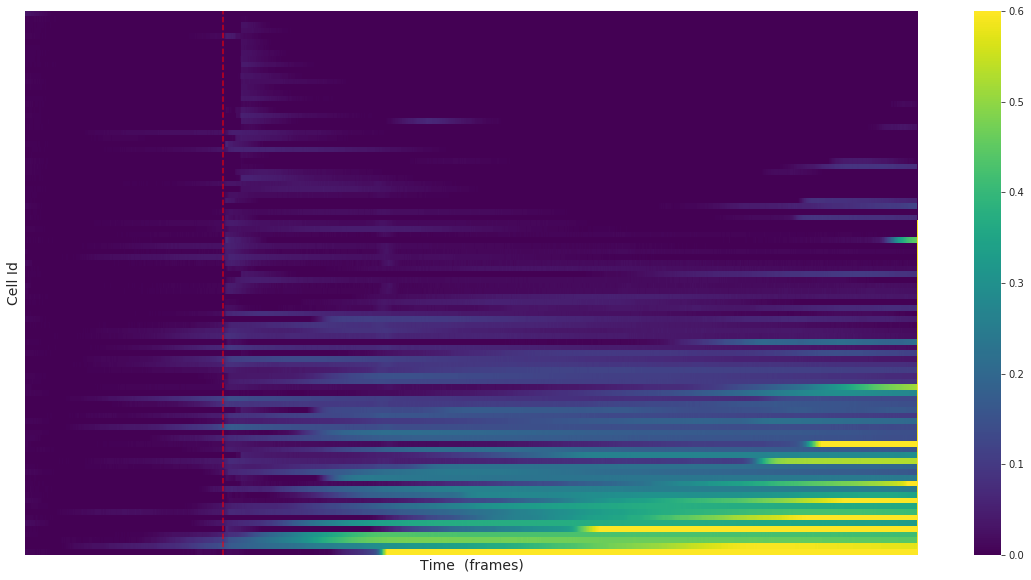

In [99]:

suma = []

for file in results_norm:
    suma.append(results_norm[file].T)
result = pd.concat(suma)

sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
fig1 = fig.add_subplot(grid[:, :])
sub_fig = fig1

#Show heatmap sorted by total intensity
result['sum'] = result.sum(axis=1)

ax =sns.heatmap(result.sort_values(by="sum",ascending = 'True'),xticklabels = False,yticklabels = False ,vmin = 0, vmax = .6, cmap = 'viridis')
plt.xlabel('Time  (frames)', size = '14')
plt.ylabel('Cell Id',size = '14')
plt.axvline(x = stim , linestyle = '--', color = 'red', alpha =0.7)


## Detect spikes and generate stats (Method 1 - manually curated for false positives)

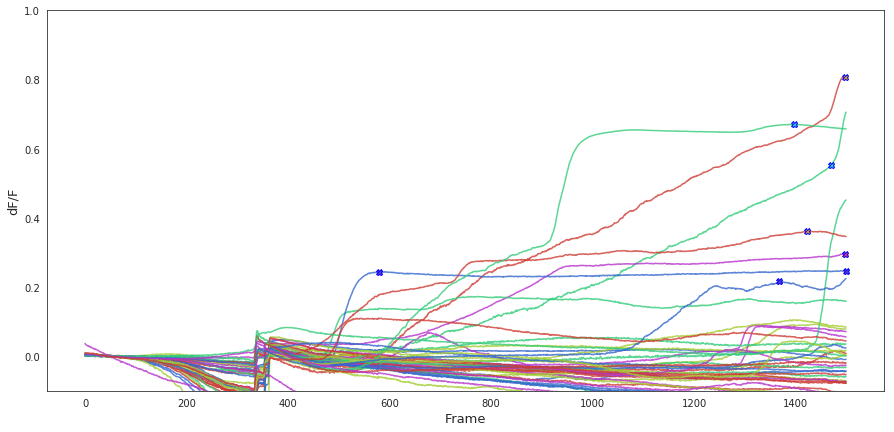

{'clone_id': 'test', 'positive': 8, 'total': 46, 'ratio': 0.17391304347826086}


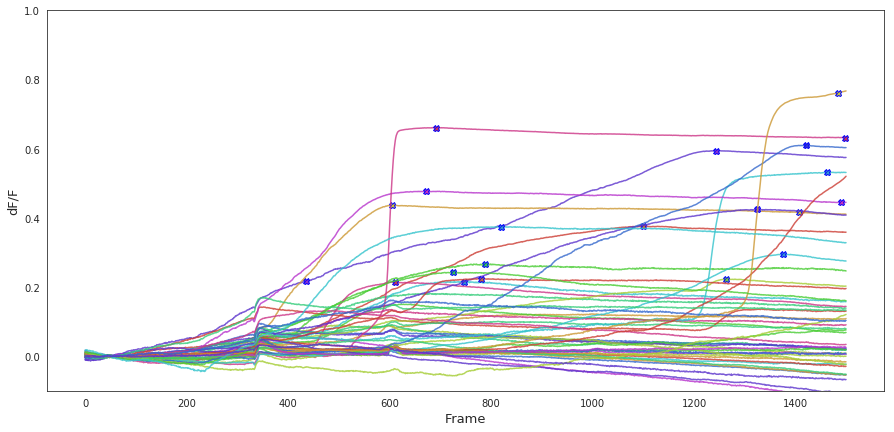

{'clone_id': 'test', 'positive': 21, 'total': 48, 'ratio': 0.4375}


In [100]:


for file in results_norm:
    
    #set style for plots
    sns.set_style("white")
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
    fig1 = fig.add_subplot(grid[:, :])
    sub_fig = fig1
    #initialize positive and total number of cells
    positive = 0
    total = 0
    for ex in np.arange(1,len(results_norm[file].columns)):
        series = results_norm[file]['Mean'+str(ex)]
        series_peaks =results_norm[file]['Mean'+str(ex)][stim:1500] 
        
        #set parameters for detect_peaks
        ind = detect_peaks(series_peaks, show=False,mph=0.20, mpd=800, threshold=0, edge='rising',kpsh=False)

        cmap = sns.hls_palette(20,l=.5, s=.6)
        sns.set_palette(cmap)
        plt.plot(series, alpha = 0.8)
        plt.xlabel("Frame",fontdict={'fontsize':13})
        plt.ylabel("dF/F",fontdict={'fontsize':13})
        sub_fig.set_ylim(-0.1,1)
        total = total + 1
        #plot detected peaks and count
        try:
                plt.plot(ind+stim, series[ind+stim], 'X', mfc=None, mec='b')
                positive = positive + len(series[ind])
        except KeyError:
            continue


    plt.show()


    

    dic  ={ 
        'clone_id': mypath,
        'positive': positive,
        'total': total,
        'ratio':positive/total
        }
    print(dic)


## Get max peak amplitude for peak amplitude plots

Outputs max dF/F for each trace following ultrasound stimulation

In [101]:
   
amplitude = 0
for file in results_norm:
    maxim = 0
    N = 0
    trials = []
    positive = 0
    total = 0
    i = 0
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        N = N +1
        series = results_norm[file]['Mean'+str(ex)]
        series_peaks =results_norm[file]['Mean'+str(ex)][stim:1500]
        ind = detect_peaks(series_peaks, show=False,mph=0.20, mpd=600, threshold=0, edge='rising',kpsh=False)
        #if len(ind)==0:
            #continue


        #else:
        maxim= max(series_peaks)
        print(maxim)



0.015588676241406196
0.021668407320522522
0.028893360440277002
0.04253460968032652
0.031869274525958974
0.8082761997685218
0.042906938914928514
0.7054340166886893
0.048354007491435605
0.2957980082994452
0.02529858303480643
0.09269764047162746
0.1727462454487864
0.020372629877517902
0.08680025279601225
0.027080596967238003
0.005609557384801405
0.023332466108691153
0.247339187248533
0.08956842132358123
0.03496416088866807
0.026158987469395684
0.4513798971078324
0.02833859002833213
0.06913572345071352
0.036233826227017464
0.05578593550180151
0.05500569677233814
0.021744283909626645
0.02921173825549457
0.36108633944011126
0.032337746208940185
0.015163227599211848
0.03347841998221809
0.036619275416572304
0.05293630456218529
0.10539584814151232
0.6703047210080113
0.04032247332013605
-0.02612285854857627
0.059375710088390134
0.04365957676656541
0.08321123034781314
0.22450246276463617
0.04332602231722968
0.37575911335411494
0.12227369880815876
0.08992140961609342
0.15031207631063584
0.18126691

# Time analysis GCaMP spikes

Analyze latency to 63% of response in traces after ultrasound stimulation. Generates plots showing traces and where 63% of max response is reached, along with a histogram. 

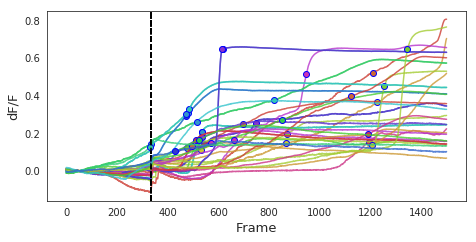

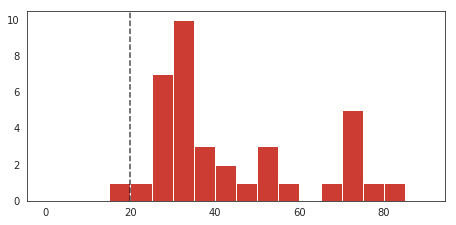

In [50]:
from math import exp
ind63 = []
fig = plt.figure(figsize=(7.5, 3.5))
for file in results_norm:
    maxim = 0
    N = 0
    trials = []
    positive = 0
    total = 0
    i = 0
    
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        t_t = 350 #don't detect peaks before stim
        series = results_norm[file]['Mean'+str(ex)]
        series_peaks =results_norm[file]['Mean'+str(ex)][t_t:1500]
        ind = detect_peaks(series_peaks, show=False,mph=0.15, mpd=800, threshold=0, edge='rising',kpsh=False)
        ##calculate rise time
        for index in ind:
            #print(ind)
            Vm_rise63 = (1-(1/exp(1)))*( series[index+t_t]-series[0])
            Vm_rise = Vm_rise63 + series[0]
            data_rise = series[0:(index+t_t)] #Vm during rise phase of EJP only
            try:
                ind_rise = 0 + np.argwhere(data_rise.rolling(window = 30).mean()>Vm_rise)[0]#index of time for 63% change
                ind63.append(int(ind_rise))

            except IndexError:
                continue

            cmap = sns.hls_palette(20,l=.5, s=.6)
            sns.set_palette(cmap)
            #if series[400]>0.1:
             #   continue

            plt.plot(series, alpha = 0.8)
            plt.axvline(x = 333 , linestyle = '--', color = 'black', alpha =0.7)

            plt.xlabel("Frame",fontdict={'fontsize':13})
            plt.ylabel("dF/F",fontdict={'fontsize':13})

            total = total + 1
            try:
                    plt.plot(ind_rise, series[ind_rise], 'o', mfc=None, mec='b')
                    positive = positive + len(series[ind])

            except KeyError:
                continue
       
        
fig = plt.figure(figsize=(7.5, 3.5))
ind63_seconds = []
for element in ind63:
    ind63_seconds.append (int(element/16.67))

plt.hist(ind63_seconds,bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])
plt.axvline(x = 20 , linestyle = '--', color = 'black', alpha =0.7)



## Looking for transient responses in HEK cells

In [53]:
#read csv files generated with ImageJ

mypath = 'transient/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

results = {}
for file in onlyfiles:
    if file.endswith('.csv'):
        results[path.splitext(file)[0]] = pd.read_csv(join(mypath,file), sep = ',')

#choose frame to normalize and get dF/F
frame = 100
results_norm={}
for file in results:
    norm = results[file].copy()
    for ex in np.arange(1,len(results[file].columns)):

        norm['Mean'+str(ex)] =  (norm['Mean'+str(ex)]-(np.mean(norm['Mean'+str(ex)][1:frame])))/norm['Mean'+str(ex)]
        results_norm[file+'_norm'] = norm.drop(' ', axis=1)

There are different parameters that can be tweaked in order to filter out all-or-none responses from transient responses.

In [60]:
t_t = 350 #peaks before frame t_t are not considered
smooth = 30 #helps reduce noise from GCaMP channel
distance_peaks_min = 800 #mpd detect_peaks
amplitude_threshold = 0.15 #dF/F threshold to detect a peak
max_half_width_transient = 333 # half
min_half_width_transient = 35
ratio_decrease = 1.6 # if the trace has not reached 1.6 ratio decrease from max after
                # max_half_width_transient it is filtered out

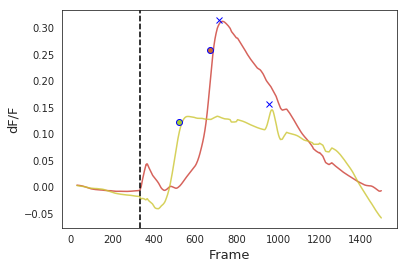

<Figure size 540x252 with 0 Axes>

In [61]:
# see https://github.com/jesshaley/EJP-analysis for a more accurate description
       
amplitude = 0
total = 0
for file in results_norm:
    maxim = 0
    N = 0
    trials = []
    positive = 0

    i = 0
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        
        series = results_norm[file]['Mean'+str(ex)]
        series_peaks =results_norm[file]['Mean'+str(ex)][t_t:1500]
        ind = detect_peaks(series_peaks, show=False,mph=amplitude_threshold, mpd=distance_peaks_min, threshold=0, edge='rising',kpsh=False)

        ##calculate rise time
        for index in ind:
            #print(ind)
            Vm_rise63 = (1-(1/exp(1)))*( series[index+t_t]-series[0])
            Vm_rise = Vm_rise63 + series[0]
            data_rise = series[0:(index+t_t)] #Vm during rise phase of EJP only
            try:
                ind_rise = 0 + np.argwhere(data_rise.rolling(window = smooth).mean()>Vm_rise)[0]#index of time for 63% change
                ind63.append(int(ind_rise))

            except IndexError:
                continue

            cmap = sns.hls_palette(20,l=.5, s=.6)
            sns.set_palette(cmap)

            if np.argmax(series)+max_half_width_transient<1500:
                if np.logical_and(series[np.argmax(series)+min_half_width_transient]<series[np.argmax(series)]/ratio_decrease,ind_rise>333):
                    continue
                elif np.logical_and(series[np.argmax(series)+max_half_width_transient]<series[np.argmax(series)]/ratio_decrease,ind_rise>333):

                    plt.plot(series.rolling(window = smooth).mean(), alpha = 0.8)
                    plt.axvline(x = 333 , linestyle = '--', color = 'black', alpha =0.7)

                    plt.xlabel("Frame",fontdict={'fontsize':13})
                    plt.ylabel("dF/F",fontdict={'fontsize':13})

                    total = total + 1
                    try:
                            plt.plot(ind_rise, series[ind_rise], 'o', mfc=None, mec='b')
                            plt.plot(np.argmax(series), series[np.argmax(series)], 'x', mfc=None, mec='b')
                            positive = positive + len(series[ind])

                    except KeyError:
                        continue
       
        
fig = plt.figure(figsize=(7.5, 3.5))
ind63_seconds = []
for element in ind63:
    ind63_seconds.append (int(element/16.67))


